# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

import inspect

In [2]:
# Conversion between b and \theta
v_theta = (np.pi/2)-np.radians(48) # (pi/2 - b) E[0,pi]
v_phi = np.radians(264) # l E[0,2pi]

In [3]:
# unit vector in R3. 
#Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function returns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Uniform stars and fixed velocity

In [4]:
beta = 1.23e-3
n_Om = 0

def vecdot(a,b): # (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=0)
    return dot
    
a=np.array([[0,1,2],[3,4,5],[6,7,8],[9,10,11]]).T#.reshape(3,4)
b=np.array([[0, 1, 1]]).reshape(3,1)
print(b)
print(np.shape(a))
print(np.shape(b))
adotb=vecdot(a,b)
print(adotb)

def hola(y):
    return np.where(y == 0, 0, np.log(y))
    #if y==0:
    #logy = 0
    #else: 
    #    logy = np.log(y)
    #return logy
    
#print(hola(np.array([2,2,1,4,5,0])))

def F0(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*(1- 8*y +7*(y**2) - 6*(y**2)*hola(y))
    den = 3* ((1-y)**2)
    return num/den

def F1(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = -np.pi*(2*y -1) *((y-1)*(2*y +1) - 3*y*hola(y))
    den = 6*((y-1)**3)
    return num/den

def F2(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*y*((y-1)*(2*y +1) - 3*y*hola(y))
    den = 3*((y-1)**2)
    return num/den

def C1(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    f0 = F0(v,n1,n2)
    f2 = F2(v,n1,n2)
    C1 = -8*y*((y-1)**2)*f0 - 8*beta*(4-n_Om)*y*(y-1)*f2*(n1v+n2v)
    return C1

def C2(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    f0 = F0(v,n1,n2)
    f2 = F2(v,n1,n2)
    C2 = 2*(y-1)*f0*(n1v*(2*y -1) + n2v) + 2*beta*(4-n_Om)*f2*(n1v+n2v)*(n1v*(2*y -1) + n2v)
    return C2

def C3(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    f0 = F0(v,n1,n2)
    f2 = F2(v,n1,n2)
    C3 = 2*n1v*(y-1)*f0*(n1v + (2*y -1)*n2v) + 2*beta*(n_Om-4)*f2*(n1v+n2v)*(n1v*n2v*(2*y -1)+(n2v)**2 +4*(y-1)*y)
    return C3


[[0]
 [1]
 [1]]
(3, 4)
(3, 1)
[ 3  9 15 21]


In [5]:
def Cnull(v,p,q):
    y = (1-vecdot(p,q))/2
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    f0 = F0(v,p,q)
    f2 = F2(v,p,q)
    Cnull = C1(v,p,q) + ((4*(y-1)*y)/(n1v*(2*y-1) +n2v))*C2(v,p,q)
    return Cnull

def Cdip(v,p,q):
    y = (1-vecdot(p,q))/2
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    Cdip = ((n1v*(n1v + n2v*(2*y -1))*C1(v,p,q))/(4*(y-1)*y) + C3(v,p,q))/beta
    return Cdip

def Cmon(v,p,q):
    y = (1-vecdot(p,q))/2
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    Cmon =  ( (n1v*n2v*(2*y-1) + n2v**2 + 4*(y-1)*y)*C1(v,p,q) )/(4*(1-y)*y) + C3(v,p,q)
    return Cmon

#print(inspect.getsource(F0))

In [6]:
np.random.seed(4)
random_vector = np.random.randn(3)
random_vector2 = np.random.randn(3)
#v = random_vector / np.linalg.norm(random_vector)
n11 = random_vector / np.linalg.norm(random_vector)
n12 = random_vector2 / np.linalg.norm(random_vector2)

print('n11:', n11)
print('n12:', n12)
print(np.dot(n11,n11))

ndir = np.array([n11,n12]).T

v = skyvec(v_theta, v_phi).reshape(3,1)

#n1 = np.array([[0,1,2],[3,4,5]]).T
#n1 = np.array(random_vector / np.linalg.norm(random_vector)).T
n2 = np.array(random_vector / np.linalg.norm(random_vector2)).reshape(3,1)

print('ndir:', ndir)
print('n2:', n2)
print('v:', v)

print('C11:', C1(v,np.array([n11]).T,n2))
print('C22:', C2(v,np.array([n11]).T,n2))
print('Cnull11:',Cnull(v,np.array([n11]).T,n2))

print('C1:',C1(v,ndir,n2))
print('C2:',C2(v,ndir,n2))
print('Cnull:',Cnull(v,ndir,n2))

y11 = (1-vecdot(np.array([n11]).T,n2))/2
pv11 = vecdot(np.array([n11]).T,v)
qv11 = vecdot(n2,v)
C1s11 = C1(v,np.array([n11]).T,n2)
C2s11 = C2(v,np.array([n11]).T,n2)
Cnull_11 = C1s11 + ((4*(y11-1)*y11)/(pv11*(2*y11 -1) +qv11))*C2s11

print('n11dotn2',vecdot(np.array([n11]).T,n2))
print('n11dotV:',pv11)
print('n2dotV:',qv11)
print('Cnull_11:',Cnull_11)


n11: [ 0.04532646  0.44818547 -0.89279073]
n12: [ 0.38975189 -0.23505501 -0.8904171 ]
1.0000000000000002
ndir: [[ 0.04532646  0.38975189]
 [ 0.44818547 -0.23505501]
 [-0.89279073 -0.8904171 ]]
n2: [[ 0.028412  ]
 [ 0.28093627]
 [-0.55962835]]
v: [[-0.06994319]
 [-0.66546504]
 [ 0.74314483]]
C11: [-0.15848988]
C22: [-2.89843256e-17]
Cnull11: [0.]
C1: [-0.15848988  0.20991155]
C2: [-2.89843256e-17 -9.63342152e-02]
Cnull: [ 0.00000000e+00 -2.77555756e-17]
n11dotn2 [0.62683037]
n11dotV: [-0.96489485]
n2dotV: [-0.6048254]
Cnull_11: [0.]


## Changing the color of the map according to a function

In [7]:
np.random.seed(5)
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)
print(unit_vector)
print(np.dot(unit_vector,unit_vector))

# Remember .T is not the same as .reshape()
print(unit_vector.T) 
print(unit_vector.reshape(3,1))

[ 0.17701851 -0.13274364  0.97521463]
1.0
[ 0.17701851 -0.13274364  0.97521463]
[[ 0.17701851]
 [-0.13274364]
 [ 0.97521463]]


dir type: <class 'numpy.ndarray'>
dir shape: (3, 12288)
v shape: (3, 1)
vn shape: (3, 1)


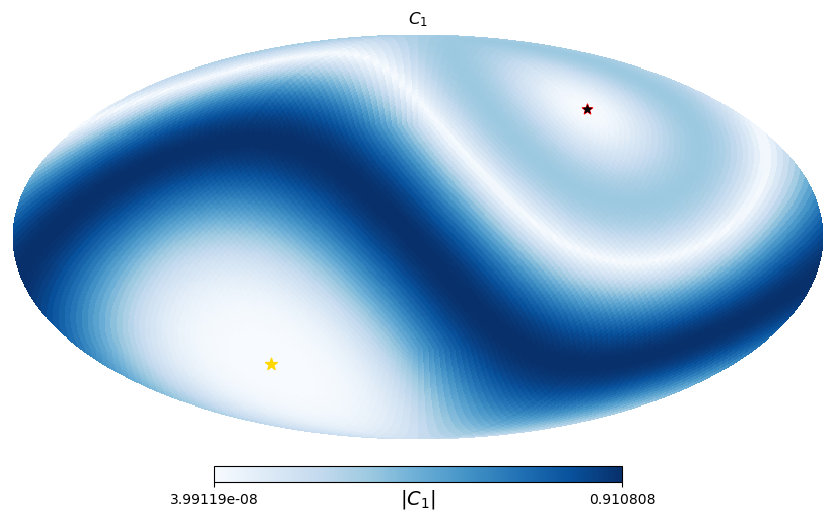

In [8]:
nside = 32 # 40 is a good number too. Kernel dies with 50 and larger numbers
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
dir = skyvec(theta,phi) #.T#.reshape(npix,3)

v = skyvec(v_theta, v_phi).reshape(3,1)
vn = skyvec(v_theta, v_phi).reshape(3,1) # Same direction as velocity 
#vn = skyvec(v_theta, v_phi+0.2).reshape(3,1) # Close to the velocity
#vn = -1.*np.array(v) # Opposite to the velocity
#vn = unit_vector.reshape(3,1) # Random position
vs = -1.*np.array(v)
thetaVn, phiVn = hp.vec2ang(vn)
thetaVs, phiVs = hp.vec2ang(vs)

print('dir type:',type(vn))
print('dir shape:',np.shape(dir))
print('v shape:',np.shape(v))
print('vn shape:',np.shape(vn))

Map_C1 = C1(v,dir,vn)

hp.mollview(abs(Map_C1),cmap='Blues',cbar=True, unit=r'$|C_{1}|$',title=r'$C_{1}$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=80,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k') 

#plt.savefig('H_00_VoppositeD.pdf',bbox_inches='tight')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/C1_PasV.pdf')#,bbox_inches='tight')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_00_StarCloseToV.pdf')


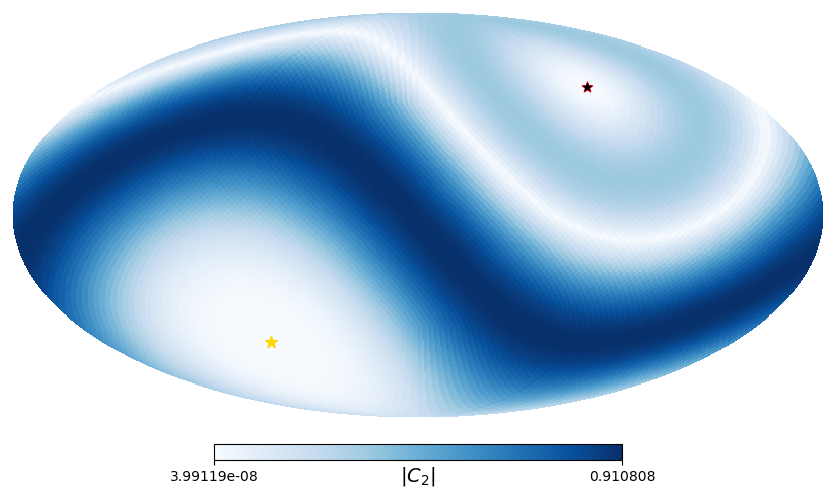

In [9]:
Map_C2 = C2(v,dir,vn)
hp.mollview(abs(Map_C2),title=r'',cmap='Blues',cbar=True, unit=r'$|C_{2}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=80,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k')  

#plt.savefig('H_11_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/C2_PasV.pdf')#,bbox_inches='tight')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_11_StarCloseToV.pdf')


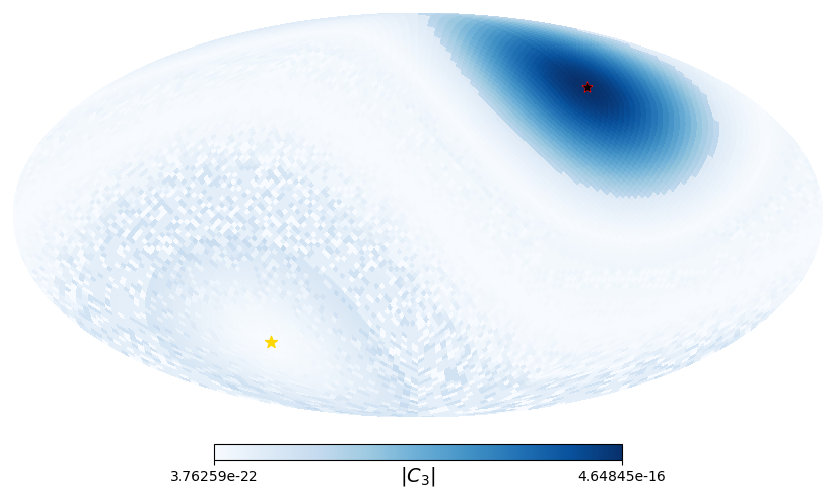

In [10]:
Map_C3 = C3(v,dir,vn)
hp.mollview(abs(Map_C3),title=r'',cmap='Blues',cbar=True, unit=r'$|C_{3}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=80,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k')  

#plt.savefig('H_22_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/C3_PasV.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_22_StarCloseToV.pdf')


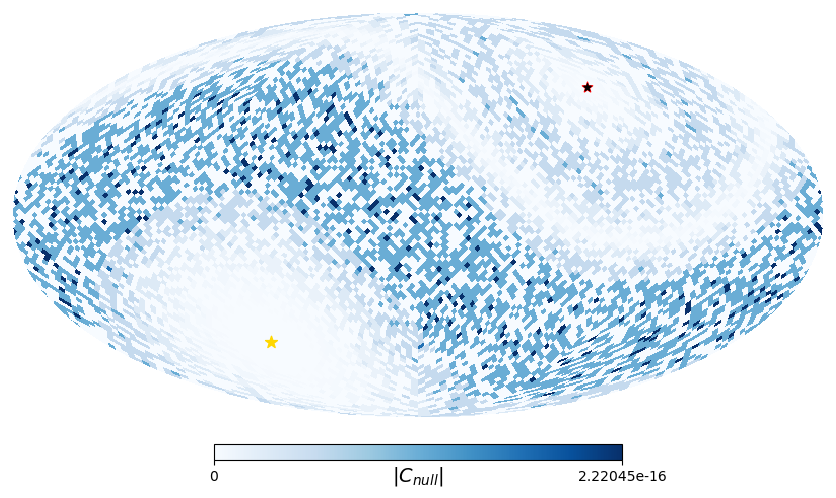

In [21]:
Map_Cnull = Cnull(v,dir,vn)

hp.mollview(abs(Map_Cnull),title=r'',cmap='Blues',cbar=True, unit=r'$|C_{null}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=80,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k')  

#plt.savefig('H_ii_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/Cnull_PasV.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_ii_StarCloseToV.pdf')

[0. 0. 0. ... 0. 0. 0.]


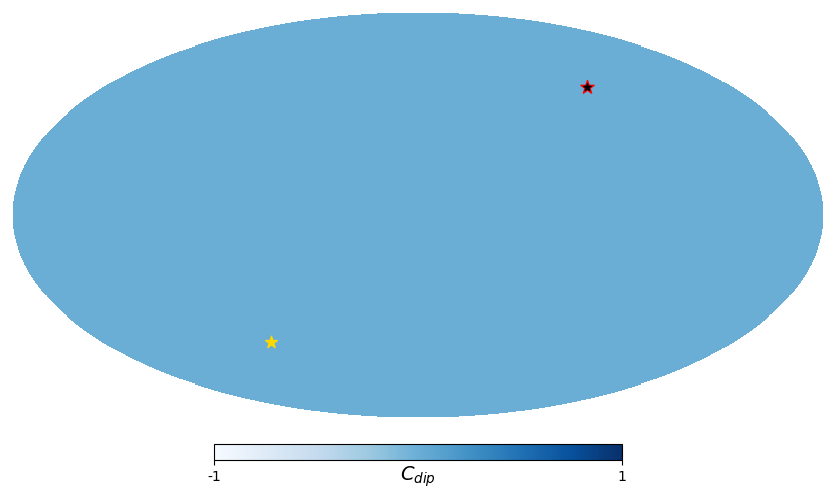

In [18]:
def MapCdip(a,b,c):
    return np.where(Cdip(a,b,c)<1e-15, 0, Cdip(a,b,c))
print(MapCdip(v,dir,vn))

Map_Cdip = Cdip(v,dir,vn)

hp.mollview(MapCdip(v,dir,vn),title=r'',cmap='Blues',cbar=True, unit=r'$C_{dip}$')
hp.projscatter(v_theta,v_phi,marker='*',s=100,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=80,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k')  

#plt.savefig('H_ii_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/Cdip_PasV.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_ii_StarCloseToV.pdf')


[0. 0. 0. ... 0. 0. 0.]


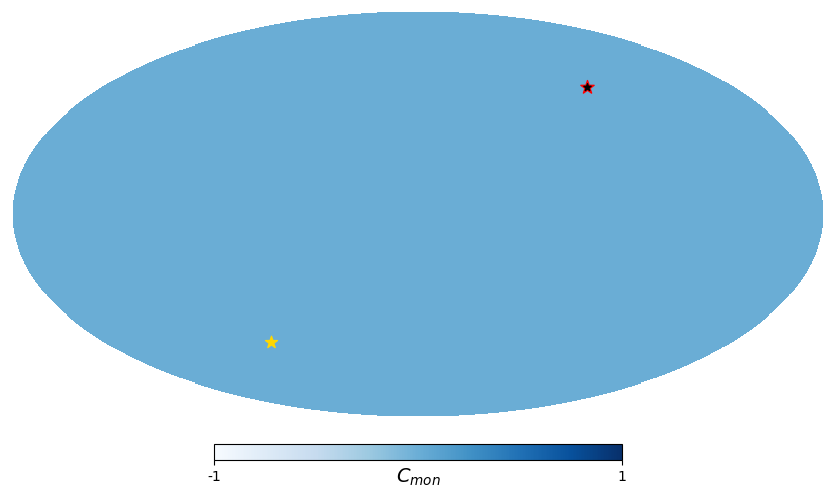

In [20]:
def MapCmon(a,b,c):
    return np.where(Cmon(a,b,c)<1e-15, 0, Cmon(a,b,c))
print(MapCmon(v,dir,vn))

Map_Cmon = Cmon(v,dir,vn)

hp.mollview(MapCmon(v,dir,vn),title=r'',cmap='Blues',cbar=True, unit=r'$C_{mon}$')
hp.projscatter(v_theta,v_phi,marker='*',s=100,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=80,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k')  

#plt.savefig('H_ii_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/Cmon_PasV.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_ii_StarCloseToV.pdf')
